In [99]:
import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
path = "/home/maria/data/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports"

In [101]:
def listFiles(path):
    """
    Retorna una lista de archivos de una ruta (path) dada.
    :param path: Ruta del directorio donde se encuentran los archivos a listar
    :return filenames
    """
    return [obj.name for obj in Path(path).iterdir() if obj.is_file()]

In [102]:
def getData(country="Venezuela",date="05-22-2020",path=path,encoding="ISO-8859-1"):
    """
    Obtiene los datos desde una fecha y para un país, de la ruta definida de archivos csv.
    :param country: País que se quiere generar el dataframe
    :param date: Fecha desde que se va a tomar los datos para el dataframe
    :param path: Ruta donde se encuentran los archivos csv
    :param encoding: Codificación a la que se encuentran los archivos csv.
    :return df: Dataframe con los datos extraídos de los csv desde una fecha dada y para un país.
    """
    # Se obtiene los nombres de los archivos.
    lista = [file for file in listFiles(path) if file.split(".")[-1] == "csv"]
    # Se lee los archivos csv y se convierten en varios dataframe en un diccionario ordenados por fecha.
    df = {item.split(".")[0]:pd.read_csv(path+ "/" +item,encoding=encoding) for item in lista}
    # Se lista las fechas
    dates = [item.split(".")[0] for item in lista]
    # Se renombras las columnas de los dataframes.
    for i,date in enumerate(dates):
        if "Country_Region" in list(df[date].columns) or "Province_State" in list(df[date].columns) or "Last_Update" in list(df[date].columns):
            df[date].rename(columns={"Country_Region": 'Country/Region',"Last_Update":"Last Update","Province_State": "Province/State"},inplace=True)
    # Se convierten las fechas en datetime y se ordenan
    dates2 = sorted([datetime.datetime.strptime(date,"%m-%d-%Y") for date in dates])
    # Se ordena los dataframes en una lista
    data = [df[d.strftime("%m-%d-%Y")][df[d.strftime("%m-%d-%Y")]["Country/Region"] == country] for d in dates2 if d >= datetime.datetime.strptime(date,"%m-%d-%Y")]
    #Se concatena los dataframes en uno sólo y se retorna
    data_df = pd.concat(data)
    return data_df

In [103]:
def AddColumnRate(df,column_name):
    """
    Agrega una columna al dataframe, dicha columna es la diferencia entre la próxima row y el row actual
    :param df: DataFrame a agregar la columna.
    :param column_name: Columna a la que se quiere calcular la diferencia.
    :return df: Retorna un dataframe con la columna adicional que tiene la diferencia por día.
    """
    elements = []
    # Se recorre el dataframe
    for i in range(len(df)):
        # Si es la fila inicial se toma su valor
        if i == 0:
            elements.append(df.iloc[0][column_name])
        else:
            # Si no es el inicial se calcula la diferencia de su valor actual con el anterior
            elements.append(df.iloc[i][column_name] - df.iloc[i-1][column_name])
    # Se agrega la lista al dataframe
    df.insert(4,f"rate_{column_name}",elements)
    return df

In [104]:
def DataProcessor(df):
    """
    Se remueve columnas del dataframe, se define el index, se reemplaza los NA y se agrega dos columnas.
    :param df: Dataframe a procesar
    :return df: DataFrame procesado
    """
    # Se obtiene el nombre de una columna a remover
    remove = list(df.columns)[0]
    # Se remueve la lista de columnas
    df.drop(labels=["Province/State","Lat","Long_","Admin2","Lat","Long_","Combined_Key","FIPS",remove],axis=1,inplace=True)
    df.drop(labels=[df.columns[-2]],axis=1,inplace=True)
    # Se reemplaza NA por 0.
    df.fillna(0,inplace=True)
    # Se conviernte las fechas que son string a datetime
    df['Last Update']= pd.to_datetime(df['Last Update'])
    # Se define las fechas como indice
    df.set_index("Last Update",inplace=True)
    # Se calcula los rate de confirmados y muertes
    df = AddColumnRate(df,"Confirmed")
    df = AddColumnRate(df,"Deaths")
    return df

In [105]:
def PlotData(df,column,title):
    """
    Gráfica una columna del dataframe
    :param df: Dataframe a gráficar
    :param column: Columna a graficar
    :param title: Título de la gŕafica
    """
    # Se recorre los países de la lista
    for i,country in enumerate(countries):
        if i == 0:
            # Si es el primer país se define el título de la gráfica
            df[country][column].plot(label=country,figsize=(16,8),title=title)
        else:
            df[country][column].plot(label=country,figsize=(16,8))
    plt.legend();

In [106]:
# Paises a analizar
countries = ["Venezuela","Colombia","Ecuador","Peru", "Chile"]


# In[9]:
# Fecha de extracción de datos
date= "05-22-2020"


# In[10]:
# Construcción de los dataframes
df = {country: getData(country=country,date=date) for country in countries}

# In[11]:
# Procesar los datos
df2 = {country: DataProcessor(df[country]) for country in countries}

In [107]:
country_="Peru"

In [108]:
df2[country_].sort_values("Last Update", ascending=False)

,Country/Region,Confirmed,Deaths,Recovered,rate_Deaths,rate_Confirmed,Active,Case-Fatality_Ratio
Last Update,,,,,,,,
2020-06-04 02:33:14,Peru,0,0,72319,-113,-4580,-72319,0.000000
2020-06-04 02:33:14,Peru,5351,212,0,192,3344,5139,3.961876
2020-06-04 02:33:14,Peru,654,26,0,26,654,628,3.975535
2020-06-04 02:33:14,Peru,4647,286,0,260,3993,4361,6.154508
2020-06-04 02:33:14,Peru,203,3,0,-283,-4444,200,1.477833
...,...,...,...,...,...,...,...,...
2020-04-22 23:30:32,Peru,19250,530,7027,46,1413,11693,0.000000
2020-04-21 23:30:30,Peru,17837,484,6982,39,1512,10371,0.000000
2020-04-20 23:36:27,Peru,16325,445,6968,45,697,8912,0.000000


In [109]:
plotcountry = "Venezuela"

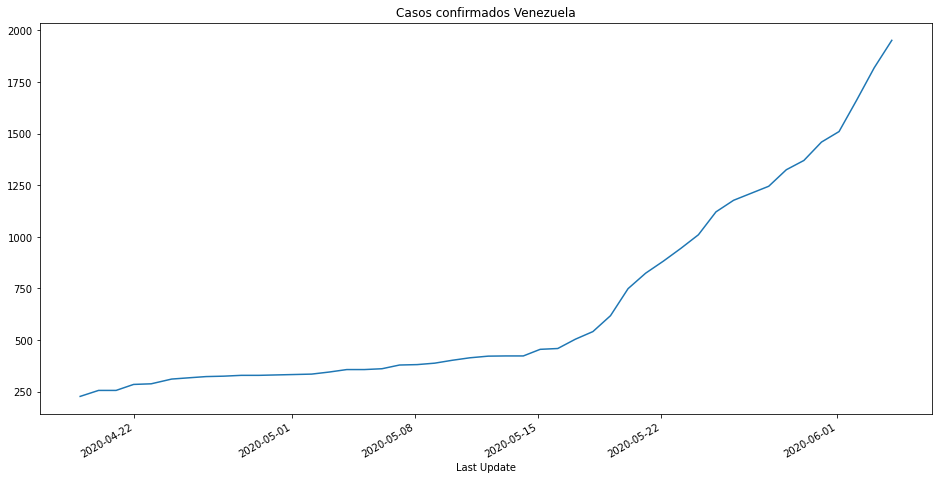

In [110]:
df[plotcountry].Confirmed.plot(label="plotcountry",figsize=(16,8),title="Casos confirmados "+plotcountry)

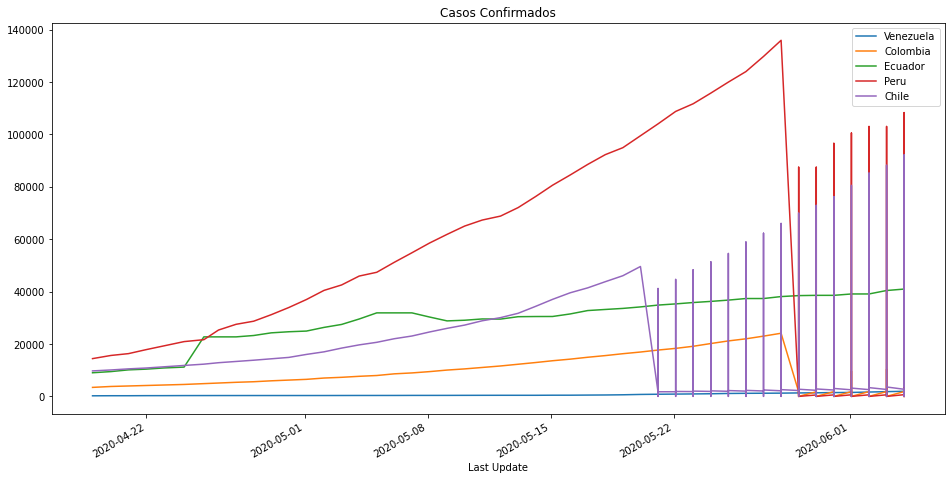

In [111]:
PlotData(df2,"Confirmed","Casos Confirmados")

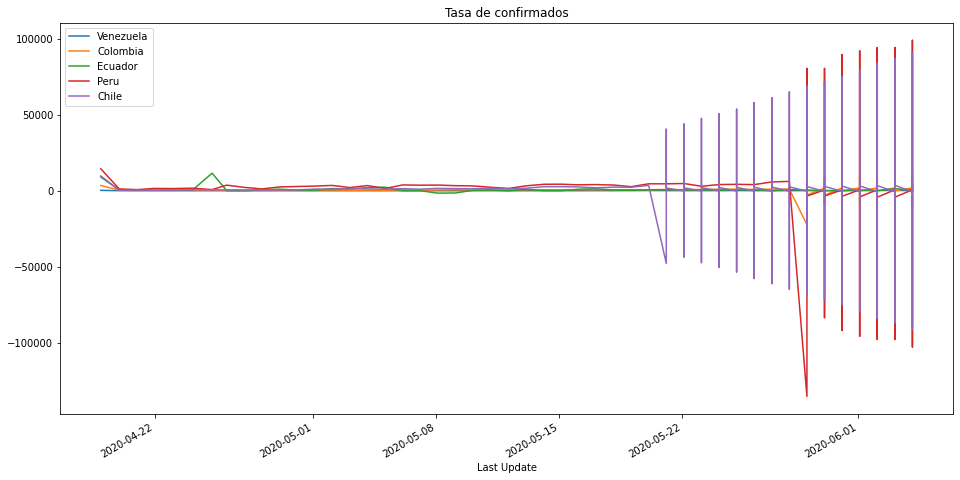

In [112]:
PlotData(df2,"rate_Confirmed","Tasa de confirmados")

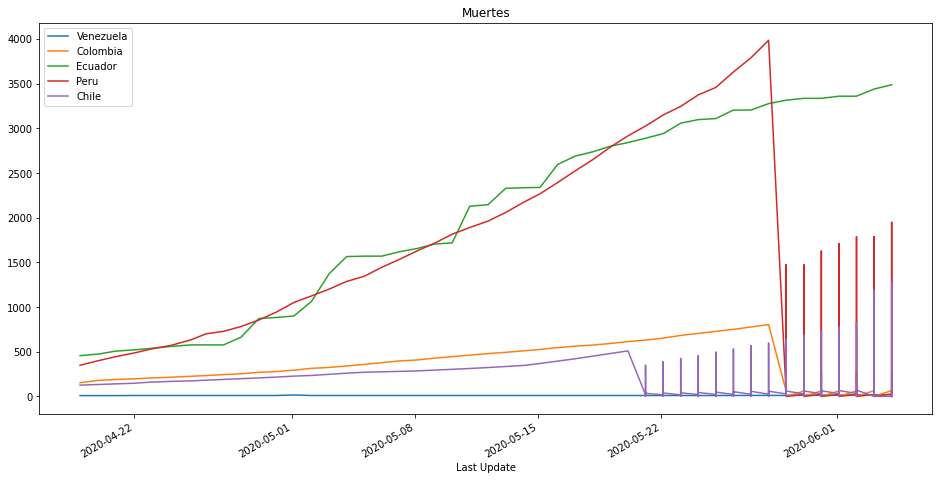

In [113]:
PlotData(df2,"Deaths","Muertes")

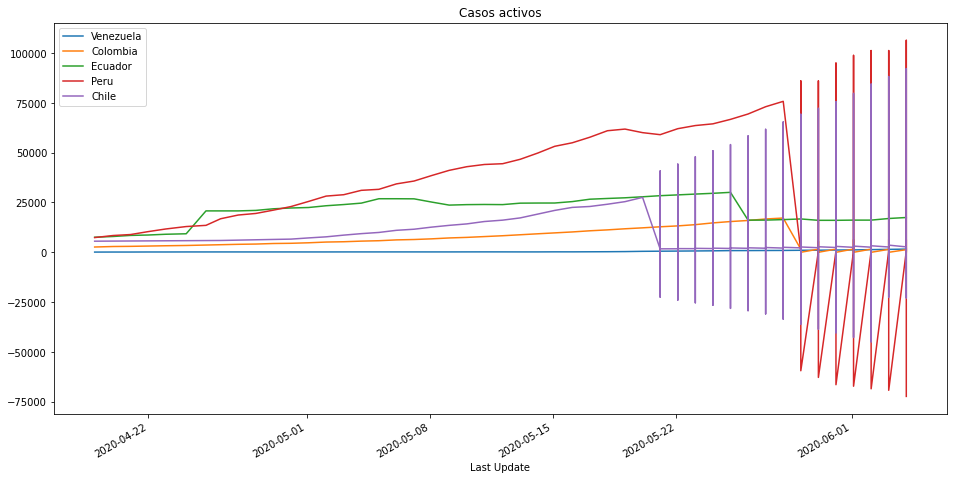

In [114]:
PlotData(df2,"Active","Casos activos")